In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
from bimpcc.models.tvdenoising_model import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 30

In [5]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(29.5), np.float64(29.5), np.float64(-0.5))

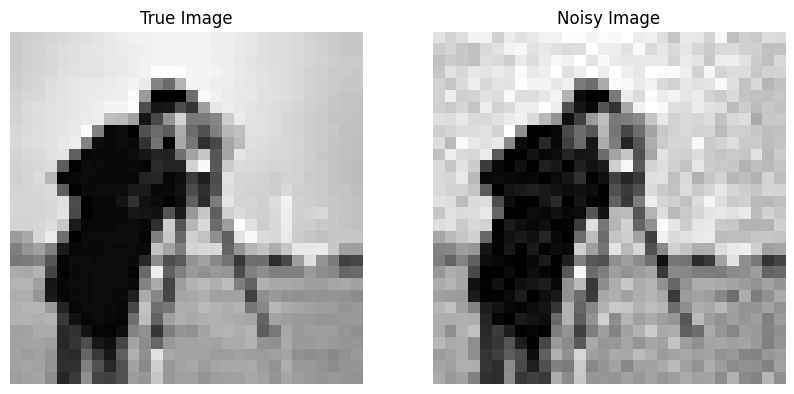

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [7]:
model = TVRegularized(true, noisy, epsilon=1e-3)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    14704
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2641
                     variables with only lower bounds:      901
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2640
Total number of inequality c

In [9]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

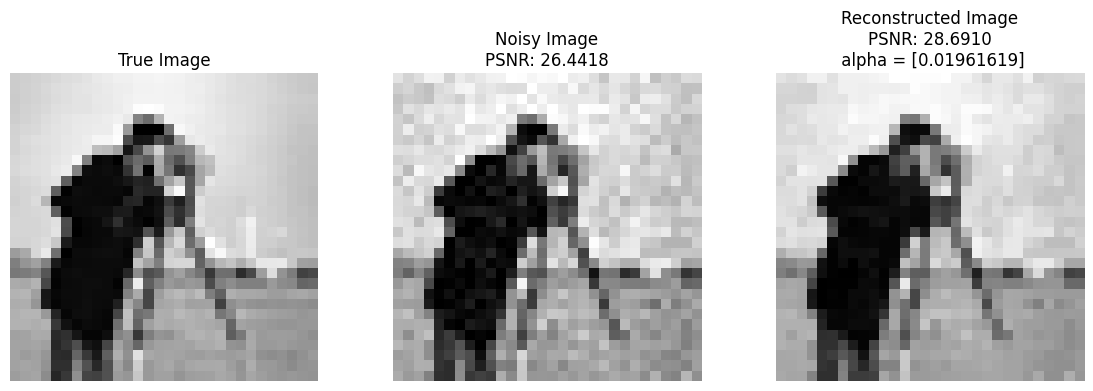

In [10]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [ ]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,np.zeros(n),alpha))
print(x0_mpcc)

[0.86182749 0.83735065 0.85708624 ... 0.         0.         0.01961619]


In [13]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3)

In [14]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-4,print_level=5,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0829234e-01 8.15e-01 1.96e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

0                 1  0.17487344642300504     6.060457100522485                  1.0

Constraint violation....:   8.0464107599098611e-13    8.0464107599098611e-13
Variable bound violation:   9.8928213643065633e-09    9.8928213643065633e-09
Complementarity.........:   1.0000000005180412e-11    1.0000000005180412e-11
Overall NLP error.......:   6.4335581398346125e-08    6.4335581398346125e-08


Number of objective function evaluations             = 3161
Number of objective gradient evaluations             = 1625
Number of equality constraint evaluations            = 3161
Number of inequality constraint evaluations          = 3161
Number of equality constraint Jacobian evaluations   = 1629
Number of inequality constraint Jacobian evaluations = 1629
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 35.713

EXIT: Solved To Acceptable Level.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constra

1                 2  0.17556604334863546     5.884108388728467                  0.5

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7556604e-01 1.99e-01 2.84e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

2                 1  0.17219023997782198     4.582507407826992                 0.25

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7219024e-01 1.17e-01 5.18e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

3                 2  0.17609321933704772     2.8587096607760083               0.125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7609322e-01 5.92e-02 7.11e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

4                 1  0.1680556504978256      1.7595977140895989              0.0625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6805565e-01 3.13e-02 7.66e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

5                 2  0.199125425321853       1.1455693417784083             0.03125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9912543e-01 1.55e-02 8.31e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

6                 2  0.25595038425941247     0.7273179153605084            0.015625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5595038e-01 9.82e-03 8.50e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

7                 2  0.34298044437584246     0.4452784685675475           0.0078125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4298044e-01 9.86e-03 9.45e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

8                 2  0.44698272447135434     0.26281410093165136         0.00390625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4698272e-01 9.73e-03 1.04e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

9                -2  0.5278289780470934      0.1682355734842412         0.001953125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4698272e-01 9.73e-03 1.04e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

10                 1  0.5033708930700813      0.1844575795206411        0.0021484375

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0337089e-01 1.00e-02 1.04e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

11                 1  0.6081806821603565      0.10793858720930742     0.0009667968750000001

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0818068e-01 1.00e-02 1.05e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

12                 1  0.7028089471178112      0.05981525846583614     0.00043505859375000006

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.0270631e-01 1.00e-02 1.05e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

13                 1  0.7973182445006657      0.02959589728888628     0.00019577636718750004

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.9652890e-01 1.00e-02 1.01e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

14                 1  0.8680834365416158      0.014433743980930726    8.809936523437502e-05

Complementarity.........:   1.0000000004722165e-11    1.0000000004722165e-11
Overall NLP error.......:   1.5782026899857769e-07    1.5782026899857769e-07


Number of objective function evaluations             = 149
Number of objective gradient evaluations             = 148
Number of equality constraint evaluations            = 149
Number of inequality constraint evaluations          = 149
Number of equality constraint Jacobian evaluations   = 148
Number of inequality constraint Jacobian evaluations = 148
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 3.603

EXIT: Solved To Acceptable Level.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
        

15                 0  0.9160400511683013      0.006556779043187438    3.964471435546876e-05

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16560
Number of nonzeros in inequality constraint Jacobian.:     4350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5251
                     variables with only lower bounds:     2641
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4380
Total number of inequality constraints...............:     1740
        inequality constraints with only lower bounds:     1740
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.1153731e-01 1.00e-02 9.86e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

16                 0  0.9344577429354384      0.0034690576240219892   1.7840121459960943e-05

Intermediate result:  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the 
convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 0.9344577429354384
       x: [ 8.856e-01  8.331e-01 ... -2.739e+00  1.879e-03]
     nit: 134
    info:     status: 0
                   x: [ 8.856e-01  8.331e-01 ... -2.739e+00  1.879e-03]
                   g: [-9.899e-09 -9.587e-09 ...  2.024e-12 -5.587e-12]
             obj_val: 0.9344577429354384
              mult_g: [-9.916e-02 -2.424e-02 ...  1.871e-01 -5.763e-02]
            mult_x_L: [ 1.129e-11  1.200e-11 ...  0.000e+00  5.322e-09]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence 
tolerances (can be specified by options).'
    nfev: 169
    njev: 136

Intermediate fn: 0.9344577429354384

complementarity: 0.0034690576240219892

* (STOPPED) Iteration 18: Solving the NLP problem for t = 1e-05 with complementarity: 0.0034690576240219892

In [16]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

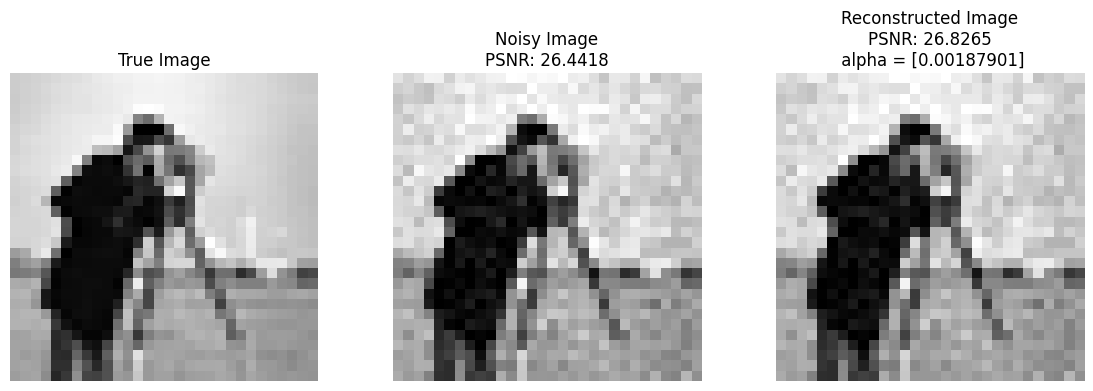

In [17]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc,alpha_mpcc)